<a href="https://colab.research.google.com/github/LapTQ/image_captioning/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/hungpham13/Vietnamese-HTR.git

Cloning into 'Vietnamese-HTR'...
remote: Enumerating objects: 2403, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2403 (delta 0), reused 4 (delta 0), pack-reused 2399
Receiving objects: 100% (2403/2403), 427.59 MiB | 42.71 MiB/s, done.
Checking out files: 100% (2395/2395), done.


In [1]:
import os
import re
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
!head -20 '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/0825_DataSamples 1/labels.json'

{
    "1.jpg": "Số 3 Nguyễn Ngọc Vũ, Hà Nội",
    "2.jpg": "Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội",
    "3.jpg": "58 Thái Thịnh, Đống Đa, Hà Nội",
    "4.jpeg": "Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa, Đồng Nai",
    "5.jpg": "Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương, phường Vĩnh Trung",
    "6.jpg": "Tòa nhà 34T, Hoàng Đạo Thúy, Hà Nội",
    "7.jpg": "40 Cát Linh, Đống Đa, Hà Nội",
    "8.jpg": "phòng 101, tầng 1, lô 04-TT5B, khu đô thị Tây Nam Linh Đàm",
    "9.JPG": "Nhà 87 ngõ 416 Đê La Thành",
    "10.JPG": "Up coworking Space, 89 Láng Hạ, Hà Nội",
    "11.jpg": "192 Ngô Đức Kế, quận 1, Hồ Chí Minh",
    "12.jpg": "số 5 Công Trường Mê Linh, phường Bến Nghé, quận 1",
    "13.jpg": "90A đường Mai Xuân Thưởng, tỉnh Gia Lai",
    "14.jpg": "96/7/12B Phạm Văn Đồng, thành phố Pleiku",
    "15.jpg": "168 Ngô Gia Tự, thành phố Hà Tĩnh"
}

In [36]:
train_img_dir = '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/0916_Data Samples 2'
test_img_dir = '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/1015_Private Test'

image_height, image_width = 120, 1900
vocab_size = 10000
seq_length = 25
embed_dim = 512
ff_dim = 512

batch_size = 54
epochs = 30
AUTOTUNE = tf.data.AUTOTUNE

In [35]:
print('Number of training images:', len(list(Path(train_img_dir).glob('*.png'))))
print('Number of testing images:', len(list(Path(test_img_dir).glob('*.png'))))

Number of training images: 1823
Number of testing images: 549


In [41]:
import json

train_json = json.load(
    open(train_img_dir + '/labels.json', 'r')
)

test_json = json.load(
    open(test_img_dir + '/labels.json', 'r')
)

In [20]:
# max([len(label.split()) for label in json_file.values()])
# tokens = set()
# for label in json_file.values():
#     for token in label.split():
#         tokens.add(token)
# len(tokens)

2494

In [50]:
def decode_and_resize(img_path):
    img_string = tf.io.read_file(img_path)
    img = tf.image.decode_png(img_string)

    # resize to desired shape
    # input is of int [0, 255], but output is of float [0, 255]
    img = tf.image.resize_with_pad(img, image_height, image_width)

    # preprocess_input accept input of type float [0, 255]
    img = keras.applications.densenet.preprocess_input(img)

    return img

vectorization = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_length,
    standardize=lambda label: tf.strings.regex_replace(label, "[%s]" % re.escape("!\"#$%&'()*+,.:;<=>?@[\]^_`{|}~"), "")
)

vectorization.adapt(list(train_json.values()))

def preprocess_input(img_path, label):
    return decode_and_resize(img_path), vectorization(label)

def make_dataset(img_paths, labels, training):
    assert training is True or training is False

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    dataset = dataset.map(preprocess_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=2000)
    dataset = dataset.cache()
    if training: 
        dataset = dataset.shuffle(buffer_size=2000)
    dataset = dataset.batch(batch_size)

    return dataset


train_ds = make_dataset(
    [str(path) for path in sorted(list(Path(train_img_dir).glob('*.png')))],
    train_json.values(),
    training = True
)
test_ds = make_dataset(
    [str(path) for path in sorted(list(Path(test_img_dir).glob('*.png')))],
    test_json.values(),
    training = False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


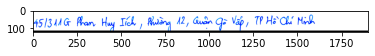

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1641   92  226  394    2  100    3   68   89    8    7    9    6    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


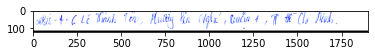

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1765   58  329  193    2   97  260    3   22    8    7    9    6    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


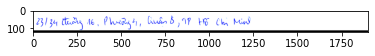

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1829   46  241    2   59    3   87    8    7    9    6    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


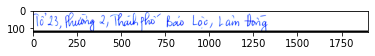

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 31 390   2  36  13  16 183  79  65  23   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


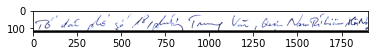

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 31 155  16  98 255   2  63  34   3  37 160 172  10  15   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


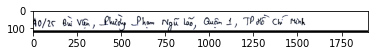

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1678  267 1050    2  114  224  250    3   22    8    7    9    6    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


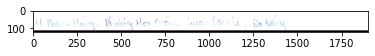

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 84 114 158   2  38  53   3 115 262  51  61   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


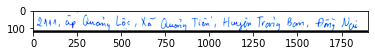

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1847   21   35   79    5   35  151    4  244  428   23   85    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


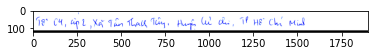

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 31 242  21  36   5  14  43  83   4 524 380   8   7   9   6   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


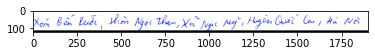

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[  86   97 1125  106  121  721    5  121   50    4  132  232   10   15
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


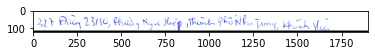

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[863  45 546   2 121 103  13  16 170 136  60  41   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


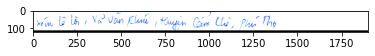

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[395  58 153   5  34 456   4 115  91  20  76   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


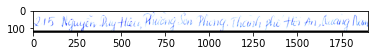

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[878  28 345 419   2  24  93  13  16 217  17  35  37   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


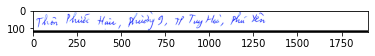

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 19  49 148   2  77   8 212  38  20  30   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


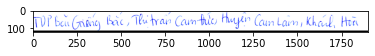

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 586  638 1322   47   18   39  425   57    4  425   65   60   41    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


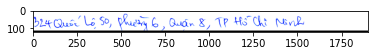

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[864 132 278 652   2  72   3  87   8   7   9   6   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


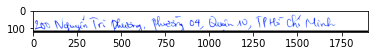

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[659  28 291 198   2 242   3  78   8   7   9   6   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


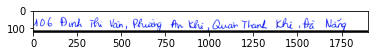

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[551 287  18 176   2  17  91   3  25  91  51  61   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


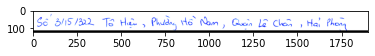

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[  11 1761  271  419    2    7   37    3   58  348   32   90    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


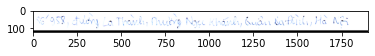

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[  11 1449   46  109   13    2  121   60    3  104   67   10   15    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


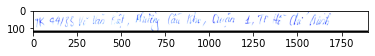

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 585 1651  143   34  225    2   88  457    3   22    8    7    9    6
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


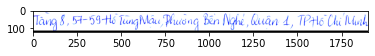

tf.Tensor(
[ 257   87 1569    7  442  509    2   97  260    3   22    8    7    9
    6    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


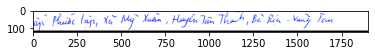

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 21  49 171   5  50  53   4  14  13  81 166  69 111 112   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


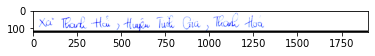

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[  5  32  25   4 156  94  25  62   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


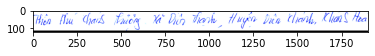

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 19  20  60 137   5 284  43   4 284  60  60  41   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


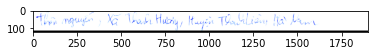

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 19  28   5  25 218   4  25 172  10  37   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


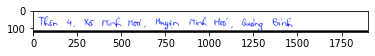

tf.Tensor(
[ 19  59   5   6 417   4   6  62  35  12   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


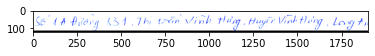

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[  11  352   45 1493   18   39   42   55    4   42   55   26   17    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


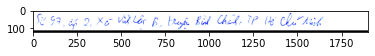

tf.Tensor(
[ 11 640  21  36   5  42  79 174   4  12 119   8   7   9   6   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


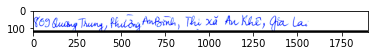

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1501   80   63    2   17   12   18   54   17   91   94   99    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


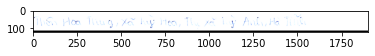

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 19 227  63   5 128 227  18  54 128 175  10 156   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


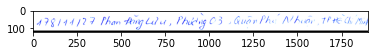

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1898   92  437  249    2  475    3   20  186    8    7    9    6    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


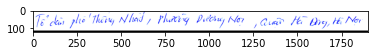

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 31 155  16 258 214   2  52  15   3  10  33  10  15   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


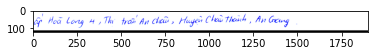

tf.Tensor(
[21 41 26 59 18 39 17 56  4 56 13 17 27  0  0  0  0  0  0  0  0  0  0  0
  0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


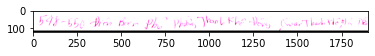

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1583  117   73  180    2   25   91   33    3   25   91   51   61    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


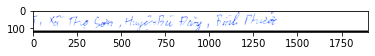

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[722   5  76  24   4 464 437  12  49   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


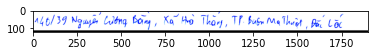

tf.Tensor(
[1949   28  162  254    5   41  169  309  261  292  184  188    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


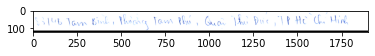

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1495  165   12    2  165   20    3  222   57    8    7    9    6    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


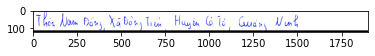

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 19  37  23   5  23 151   4 376 271  35  29   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


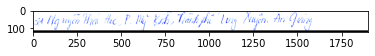

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 300   28   71 1294  293   50   12   13   40   26  168   17   27    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


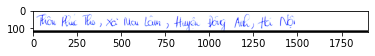

tf.Tensor(
[ 19  95  76   5  96  65   4  33 175  10  15   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


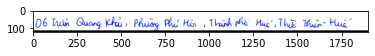

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[219  75  80 455   2  20 217  13  16 102 141 145  69 102   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


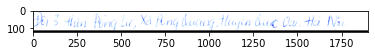

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[220  44 106  23 513   5  23  80   4 132 232  10  15   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


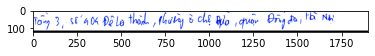

tf.Tensor(
[257  44  98 861 561 109  13   2 480 210 627   3 133 190  10  15   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


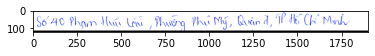

tf.Tensor(
[ 11 350 114 216 604   2  20  50   3  74   8   7   9   6   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


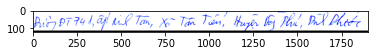

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[  45  945 1522   21    6   14    5   14  151    4   23   20   12   49
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


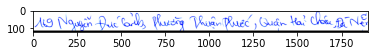

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 548   28   57 1365    2   64   49    3   32   56   51   61    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


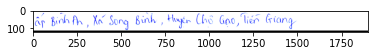

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 21  12  17   5 590  12   4 210 620 161  27   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


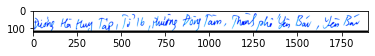

tf.Tensor(
[ 45  10 226 360  31 241   2  23 289  13  16  30 159  30 159   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


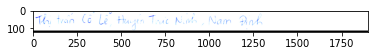

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[ 18  39 423 763   4 272  29  37  66   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


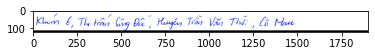

tf.Tensor(
[208  72  18 178 259 554   4  75  34 715 209 207   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


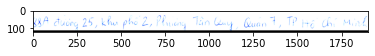

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1475   46  240  110   16   36    2   14  404    3   74    8    7    9
    6    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


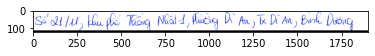

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[  11 1849  110   16  258  214   22    2  237   17  304  237   17   12
   52    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


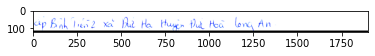

tf.Tensor(
[ 21  12 161  36   5  57  41 118   4  57  38  26  17   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


In [52]:
for images, labels in train_ds.take(1):
    for image, label in zip(images, labels):
        plt.imshow(image)
        plt.show()
        print(label)

In [ ]:
# for label in json_file.values():
#     print(
#         tf.strings.regex_replace(label, "[%s]" % re.escape("!\"#$%&'()*+,.:;<=>?@[\]^_`{|}~"), "")
#     )

In [31]:
print(list(json_file.values())[0])
vectorization(list(json_file.values())[0])

Số 253 đường Trần Phú, Thị trấn Nam Sách, Huyện Nam Sách, Hải Dương


<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([ 11, 875,  46,  75,  20,  18,  39,  37, 369,   4,  37, 369,  32,
        52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>

## References
1. https://arxiv.org/pdf/1703.09137.pdf
2. https://viblo.asia/p/a-guide-to-image-captioning-part-1-gioi-thieu-bai-toan-sinh-mo-ta-cho-anh-gAm5yr88Kdb
3. https://www.tensorflow.org/tutorials/text/image_captioning
4. https://arxiv.org/pdf/1502.03044.pdf
5. https://keras.io/examples/vision/image_captioning/
